# Para a Lecture 12  
### Modelar e Simular as propriedades da relação force-length-velocity de Thelen 2003  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math


%matplotlib inline

#### Lembretes:
  
$V^{M}$ é a velocidade da fibre muscular
$M$ vem de muscular

$L^{M}$ é o comprimento do **músculo**  

$\overline{F}\,^{M}$ é força externa que age no músculo  

No meu código, $FCE$ é o $F^{M}$ e se refere à força muscular ativa  

$ f_{L}$ é a força internano movimento contrátil  
$a \cdot f_{L} = FLNorm $  é  
$\overline{F}\,^{M} = FCENorm$  é   

$F0$ era para a curva Força Comprimento  

Estou tentando implementar as seguintes equações  

$\,\,\,\,\,\,\, V^{M} = \big(0.25+0.75a\big) \, V^{M}_{max} \, \frac{\overline{F}\,^{M} - \, af_{L}}{b}\,\,\,\,\,\,\,\,\,\,\,$  $\,\,\,\,\,\,\,\,\,\,\,(6)$


$b = \begin{cases} af_{L} + \frac{\overline{F}\,^{M}}{A_{f}} ; & \overline{F}\,^{M}\le af_{L} \\ \frac{ \big( 2+\frac{2}{A_{f}} \big) \, \cdot \, \big(af_{L}\,\overline{F}\,^{M}_{len} \, - \,\overline{F}\,^{M}\big)}{\overline{F}\,^{M}_{len} \,\, - \,\, 1 }; & \overline{F}\,^{M}\gt af_{L} \end{cases} $   $\,\,\,\,\,\,\,\,\,\,\,(7)$

A Eq. $(6)$ depende também do parâmetro $b$ da Eq. $(7)$ que depende de se a fibra está encurtando (primeiro caso) ou alongando (segundo caso).

$\overline{F}\,^{M}_{len}$ é a máxima força muscular normalizada atingível quando seu comprimento está aumentando  

$A_{f} \, = \, 0.25$


### Functions that will be used

In [2]:
def  computeTendonForce(LseeNorm, Lslack, Lce_o):
    '''
    Compute Tendon Force
    
    Inputs:
        LseeNorm - Normalized Tendon  length
        Lslack - slack length of the tendon (non-normalized)
        Lce_o - Optimal length of the fiber
    Output:
        FtendonNorm - Normalized tendon force
    '''
    
    Umax = .04
    if LseeNorm < Lslack/Lce_o: 
        FTendonNorm = 0
    else: 
        FTendonNorm = ((LseeNorm-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return FTendonNorm


In [3]:
def  computeParallelElementForce(LceNorm):
    Umax = 1
    if LceNorm < 1: 
        FkpeNorm = 0
    else: 
        FkpeNorm = ((LceNorm-1)/(Umax))**2 
        
    return FkpeNorm

In [4]:
def computeForceLengthCurve(LceNorm):
    width = .63
    FLNorm = max([0, (1-((LceNorm-1)/width)**2)])
    return FLNorm

def computeContractileElementDerivative(FLNorm, FCENorm, a, b):
     #calculate CE velocity from Hill's equation
    
    if  FCENorm > FLNorm:
        print('Error: cannot do eccentric contractions')
    
    LceNormdot = -b*(FLNorm-FCENorm)/(a+FCENorm) 
    
    return LceNormdot

In [5]:
def computeContractileElementForce(FtendonNorm, FkpeNorm, alfa):
    FCENorm = FtendonNorm/np.cos(alfa) - FkpeNorm
    return FCENorm

In [6]:
def computeTendonLength(Lm, Lce_o, LceNorm, alfa):
    LseeNorm = Lm/Lce_o - LceNorm * np.cos(alfa)
    return LseeNorm

In [7]:
def computeMuscleFiberVelocity(FCENorm, FLNorm, VMmax, a, b):
    '''
    Compute Muscle Fiber Velocity
    
    Inputs:
        FCENorm - Normalized force of Contractile Element
        FLNorm - Normalized relation of Force and Length of the contractile element
        VMmax - maximum contraction velocity        
        a - muscle activation    
        b - parameter that depends on the length of muscle fiber
    
    Output:
        Vm - muscle fiber velocity
    '''
    
    afL = a*FLNorm
    
    Vm = (0.25 + 0.75 * a) * VMmax * ((FCENorm - afL) / b)
    
    return Vm

In [8]:
def computeParameterb(FLNorm, FCENorm, Af, FlenNorm):
    '''
    Compute Parameter b
        Inputs:
            FLNorm - 
            FCENorm -
            Af -
            FlenNorm - 
        Output:
            b - 
    '''
    afL = a*FLNorm
    
    if FCENorm <= afL:
        b = afL + FCENorm / Af
    else:
        b = ((2+2/Af) * (afL*FlenNorm - FCENorm)) / (FlenNorm - 1)
            
    return b

In [9]:
def computeActivation(a, u, dt,tau_act=15e-3, tau_deact=50e-3):
    '''
    Compute Muscle Fiber Velocity,
    
    Inputs:
        a - muscle activation    
        tau_act - parameter that depends on the length of muscle fiber
        tau_deact - parameter that depends on the length of muscle fiber
    
    Output:
        Vm - muscle fiber velocity
    '''
    
        
    if u>a :
        tau_a = tau_act * (0.5 + 1.5*a)
    else:
        tau_a = tau_deact * (0.5 + 1.5*a)
    
    dadt = (u - a) / tau_a
    
    a = a + dadt * dt
    
    return a

### Signal of stimulation $u$
#### Situation 1  
$u = 1$, for t = 0 to 1  
$u = 0.5$, for t = 1 to 3  
$u = 0.01$, for t = 3 untill the end  
#### Situation 2  
$u$ as sinoid, of f = 1/2 Hz
#### Situation 3
$u = 0.01$, for t = 0 to 1  
$u = 0.1$, for t = 1 to 3  
$u = 0.01$, for t = 0 to 1 and for t = 3 untill the end

In [10]:
# sit_u = 1 # Situation 1

# sit_u = 2 # Situation 2

# sit_u = 3 # Situation 3

sit_u=0

Now the muscle has an angle, taking the penation of the muscle into account  
$L_{T} = L_{MT} - L_{M}\,cos(\alpha)$

## Simulation

* Muscle Proporties

In [11]:
Lslack = .223
Lce_o = .093 #optmal length
Fmax = 3000
FlenNorm = 1.4 # parameter of the paper for young
LceNorm = .087/Lce_o

VMmax = 10 # for young 

Af = 0.25 # according to Thelen(2003) paper

tau_act = 15e-3 # for young
tau_deact = 50e-3

* Initial Condition

In [12]:
LceNorm = .087/Lce_o
t0 = 0
tf = 4.99
h = 1e-3 # dt
dt = h

* Initializations

In [13]:
a = 0.01
u = 1

t = np.arange(t0,tf,h)

F = np.empty(t.shape)

Fkpe = np.empty(t.shape)

fiberLength = np.empty(t.shape)

tendonLength = np.empty(t.shape)

Vm = np.empty(t.shape)

Activation = np.empty(t.shape)

U = np.empty(t.shape)

* Angle of penation

In [14]:
angulo = 30
alfa = angulo * np.pi/360

### Euler Simulation

In [15]:
for i in range (len(t)):
    
    if sit_u == 1 : # SITUATION 1
        if t[i]<=1:
            u = 1
        elif t[i]>1 and t[i]<=3:
            u = 0.5
        elif t[i]>3:
            u = 0.01
            
    elif sit_u == 2:  # SITUATION 2 
        f = 1/2 # [Hz]
        u = 0.7 + 0.2*np.sin(2*np.pi*f*t[i])
    
    elif sit_u == 3: # SITUATION 3
        if t[i]<=1:
            u = 0.01
        elif t[i]>1 and t[i]<=3:
            u = 1
        elif t[i]>3:
            u = 0.01
    
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        
        
    ########################################################   
    LseeNorm = computeTendonLength(Lm, Lce_o, LceNorm, alfa)
    
    FTendonNorm = computeTendonForce(LseeNorm, Lslack, Lce_o)
        
    FkpeNorm = computeParallelElementForce(LceNorm)
      
    FLNorm = computeForceLengthCurve(LceNorm)    
    
    FCENorm = computeContractileElementForce(FTendonNorm, FkpeNorm, alfa)
    
    a = computeActivation(a, u, dt)
    
    b = computeParameterb(FLNorm, FCENorm, Af, FlenNorm) # Implemented
    
    LceNormdot = computeMuscleFiberVelocity(FCENorm, FLNorm, VMmax, a, b) # Implemented
    
    LceNorm = LceNorm + h*LceNormdot    
    #########################################################################
    
    F[i] = FTendonNorm * Fmax
    fiberLength[i] = LceNorm * Lce_o
    tendonLength[i] = LseeNorm * Lce_o
    Vm[i] = LceNormdot
    Activation[i] = a
    U[i] = u

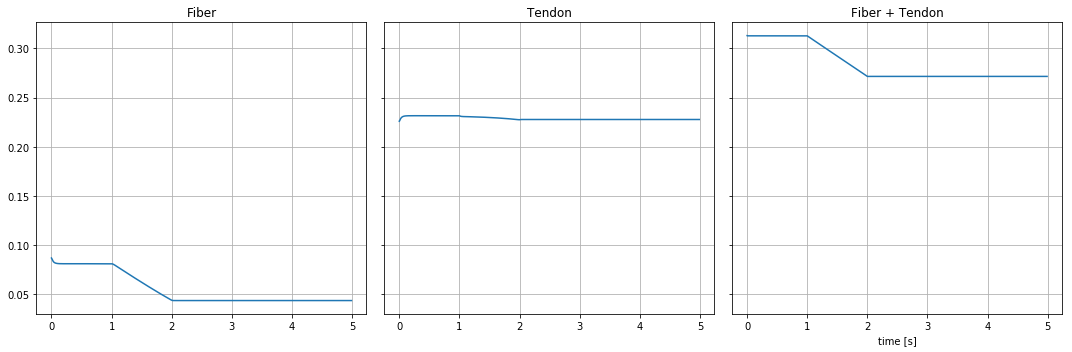

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

ax[0].plot(t, fiberLength, label='Fiber')
ax[0].set_title('Fiber')
ax[0].grid()
ax[1].plot(t, tendonLength, label='Tendon')
ax[1].set_title('Tendon')
ax[1].grid()
plt.xlabel('time [s]')
ax[2].plot(t, fiberLength+tendonLength , label='Fiber+Tendon')
ax[2].set_title('Fiber + Tendon')
ax[2].grid()
plt.tight_layout()

Text(0,0.5,'u-values during the simulation')

<Figure size 432x288 with 0 Axes>

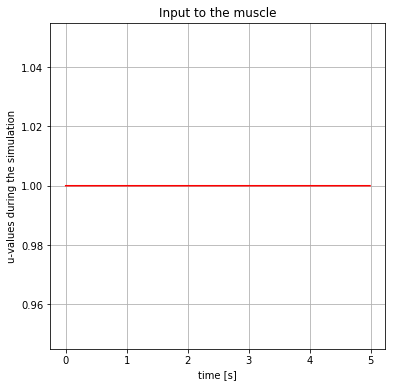

In [17]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize = (6,6),sharex=True)

ax.plot(t,U,c='red')
ax.set_title('Input to the muscle')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('u-values during the simulation')

Text(0,0.5,'a-values during the simulation')

<Figure size 432x288 with 0 Axes>

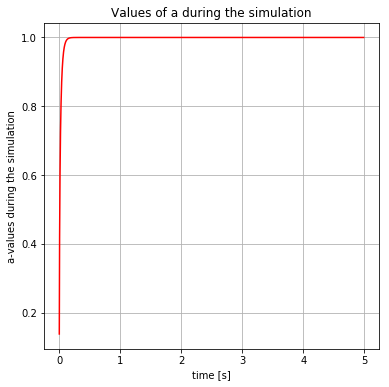

In [18]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize = (6,6),sharex=True)

ax.plot(t,Activation,c='red')
ax.set_title('Values of a during the simulation')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('a-values during the simulation')

Text(35.75,0.5,'Force [N]')

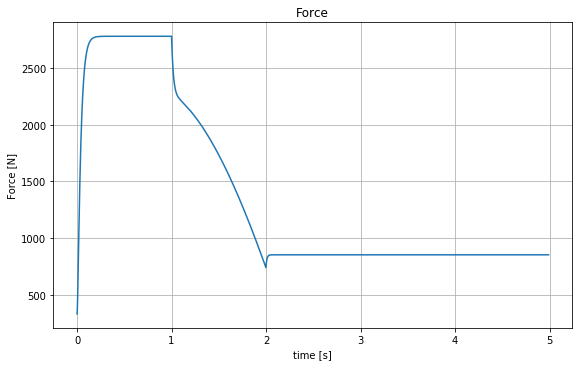

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), sharex=True)

ax.plot(t, F)
ax.set_title('Force')
ax.grid()

plt.tight_layout()

plt.xlabel('time [s]')
plt.ylabel('Force [N]')